In [4]:
import math
import numpy as np

def calculate_distance(lat1, lon1, lat2, lon2):
    R = 6371000  # Bán kính Trái Đất tính bằng mét

    # Chuyển đổi độ sang radian
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    distance = R * c
    return distance

def calculate_angles(pixel, resolution, hfov, vfov, tilt_angle):
    hfov_rad = math.radians(hfov)
    vfov_rad = math.radians(vfov)
    tilt_angle_rad = math.radians(tilt_angle)

    # Calculate alpha angle (horizontal)
    alpha = -math.atan((pixel[0] - resolution[0]/2) / (resolution[0]/2) * math.tan(hfov_rad/2))

    # Calculate beta angle (vertical)
    beta = tilt_angle_rad + math.atan((pixel[1] - resolution[1]/2) / (resolution[1]/2) * math.tan(vfov_rad/2))

    return alpha, beta

def calculate_direction_vector(alpha, beta, is_camera2=False):
    if not is_camera2:
        costhetax = math.sqrt(1 - math.sin(alpha)**2 - math.sin(beta)**2)
        costhetay = math.sin(alpha)
        costhetaz = math.sin(beta)
    else:
        costhetax = -math.sqrt(1 - math.sin(alpha)**2 - math.sin(beta)**2)
        costhetay = -math.sin(alpha)
        costhetaz = math.sin(beta)
    
    return np.array([costhetax, costhetay, costhetaz])

def find_closest_point(P1, P2, M1, M2):
    v = P2 - P1
    t = np.dot(np.cross(v, M2), np.cross(M1, M2)) / np.linalg.norm(np.cross(M1, M2))**2
    s = np.dot(np.cross(v, M1), np.cross(M1, M2)) / np.linalg.norm(np.cross(M1, M2))**2
    
    Pc1 = P1 + t * M1
    Pc2 = P2 + s * M2
    
    return (Pc1 + Pc2) / 2

def calculate_aircraft_position(lat1, lon1, alt1, lat2, lon2, alt2, pixel1, pixel2, resolution, hfov, vfov, tilt_angle):
    # Tính khoảng cách giữa hai camera
    D = calculate_distance(lat1, lon1, lat2, lon2)

    # Thiết lập vị trí camera cho tính toán, bao gồm cả độ cao
    camera1_pos = np.array([0, 0, alt1])
    camera2_pos = np.array([D, 0, alt2])

    # Tính các góc alpha và beta cho cả hai camera
    alpha1, beta1 = calculate_angles(pixel1, resolution, hfov, vfov, tilt_angle)
    alpha2, beta2 = calculate_angles(pixel2, resolution, hfov, vfov, tilt_angle)

    # Tính vector hướng cho cả hai camera
    M1 = calculate_direction_vector(alpha1, beta1)
    M2 = calculate_direction_vector(alpha2, beta2, is_camera2=True)

    # Tìm điểm gần nhất (vị trí máy bay)
    aircraft_position = find_closest_point(camera1_pos, camera2_pos, M1, M2)

    # Chiều cao của máy bay chính là tọa độ z của aircraft_position
    aircraft_height = aircraft_position[2]

    # Tính khoảng cách từ điểm ảnh đến từng camera
    distance_to_camera1 = np.linalg.norm(aircraft_position - camera1_pos)
    distance_to_camera2 = np.linalg.norm(aircraft_position - camera2_pos)

    return D, aircraft_height, aircraft_position, M1, M2, alpha1, alpha2, beta1, beta2, distance_to_camera1, distance_to_camera2, camera1_pos, camera2_pos

# Sử dụng hàm
lat1, lon1, alt1 = 21.028511, 105.804817, 100  # Tọa độ và độ cao camera 1
lat2, lon2, alt2 = 21.028511, 105.854817, 1000  # Tọa độ và độ cao camera 2
pixel1 = (1560, 540)
pixel2 = (760, 540)
resolution = (1920, 1080)
hfov = 30
vfov = 30
tilt_angle = 65

D, aircraft_height, aircraft_position, M1, M2, alpha1, alpha2, beta1, beta2, distance_to_camera1, distance_to_camera2, camera1_pos, camera2_pos = calculate_aircraft_position(
    lat1, lon1, alt1, lat2, lon2, alt2, pixel1, pixel2, resolution, hfov, vfov, tilt_angle)

print(f"Khoảng cách giữa hai camera: {D:.2f} meters")
print(f"Chiều cao của máy bay: {aircraft_height:.2f} meters")
print(f"Góc giữa đường thẳng nối cam 1 và điểm ảnh với XOZ (Alpha1): {math.degrees(alpha1):.2f} degrees")
print(f"Vị trí máy bay (tuyệt đối): ({aircraft_position[0]:.2f}, {aircraft_position[1]:.2f}, {aircraft_position[2]:.2f}) meters")
print(f"Khoảng cách từ điểm ảnh đến camera 1: {distance_to_camera1:.2f} meters")
print(f"Khoảng cách từ điểm ảnh đến camera 2: {distance_to_camera2:.2f} meters")
print(f"Alpha2 (degrees): {math.degrees(alpha2):.2f}")
print(f"Beta1 (degrees): {math.degrees(beta1):.2f}")
print(f"Beta2 (degrees): {math.degrees(beta2):.2f}")
print(f"Direction vector M1: ({M1[0]:.4f}, {M1[1]:.4f}, {M1[2]:.4f})")
print(f"Direction vector M2: ({M2[0]:.4f}, {M2[1]:.4f}, {M2[2]:.4f})")
print(f"Camera 1 position: ({camera1_pos[0]:.2f}, {camera1_pos[1]:.2f}, {camera1_pos[2]:.2f}) meters")
print(f"Camera 2 position: ({camera2_pos[0]:.2f}, {camera2_pos[1]:.2f}, {camera2_pos[2]:.2f}) meters")



Khoảng cách giữa hai camera: 5189.48 meters
Chiều cao của máy bay: 6266.48 meters
Góc giữa đường thẳng nối cam 1 và điểm ảnh với XOZ (Alpha1): -9.51 degrees
Vị trí máy bay (tuyệt đối): (2679.16, -720.89, 6266.48) meters
Khoảng cách từ điểm ảnh đến camera 1: 6761.88 meters
Khoảng cách từ điểm ảnh đến camera 2: 5878.54 meters
Alpha2 (degrees): 3.20
Beta1 (degrees): 65.00
Beta2 (degrees): 65.00
Direction vector M1: (0.3890, -0.1652, 0.9063)
Direction vector M2: (-0.4189, -0.0557, 0.9063)
Camera 1 position: (0.00, 0.00, 100.00) meters
Camera 2 position: (5189.48, 0.00, 1000.00) meters


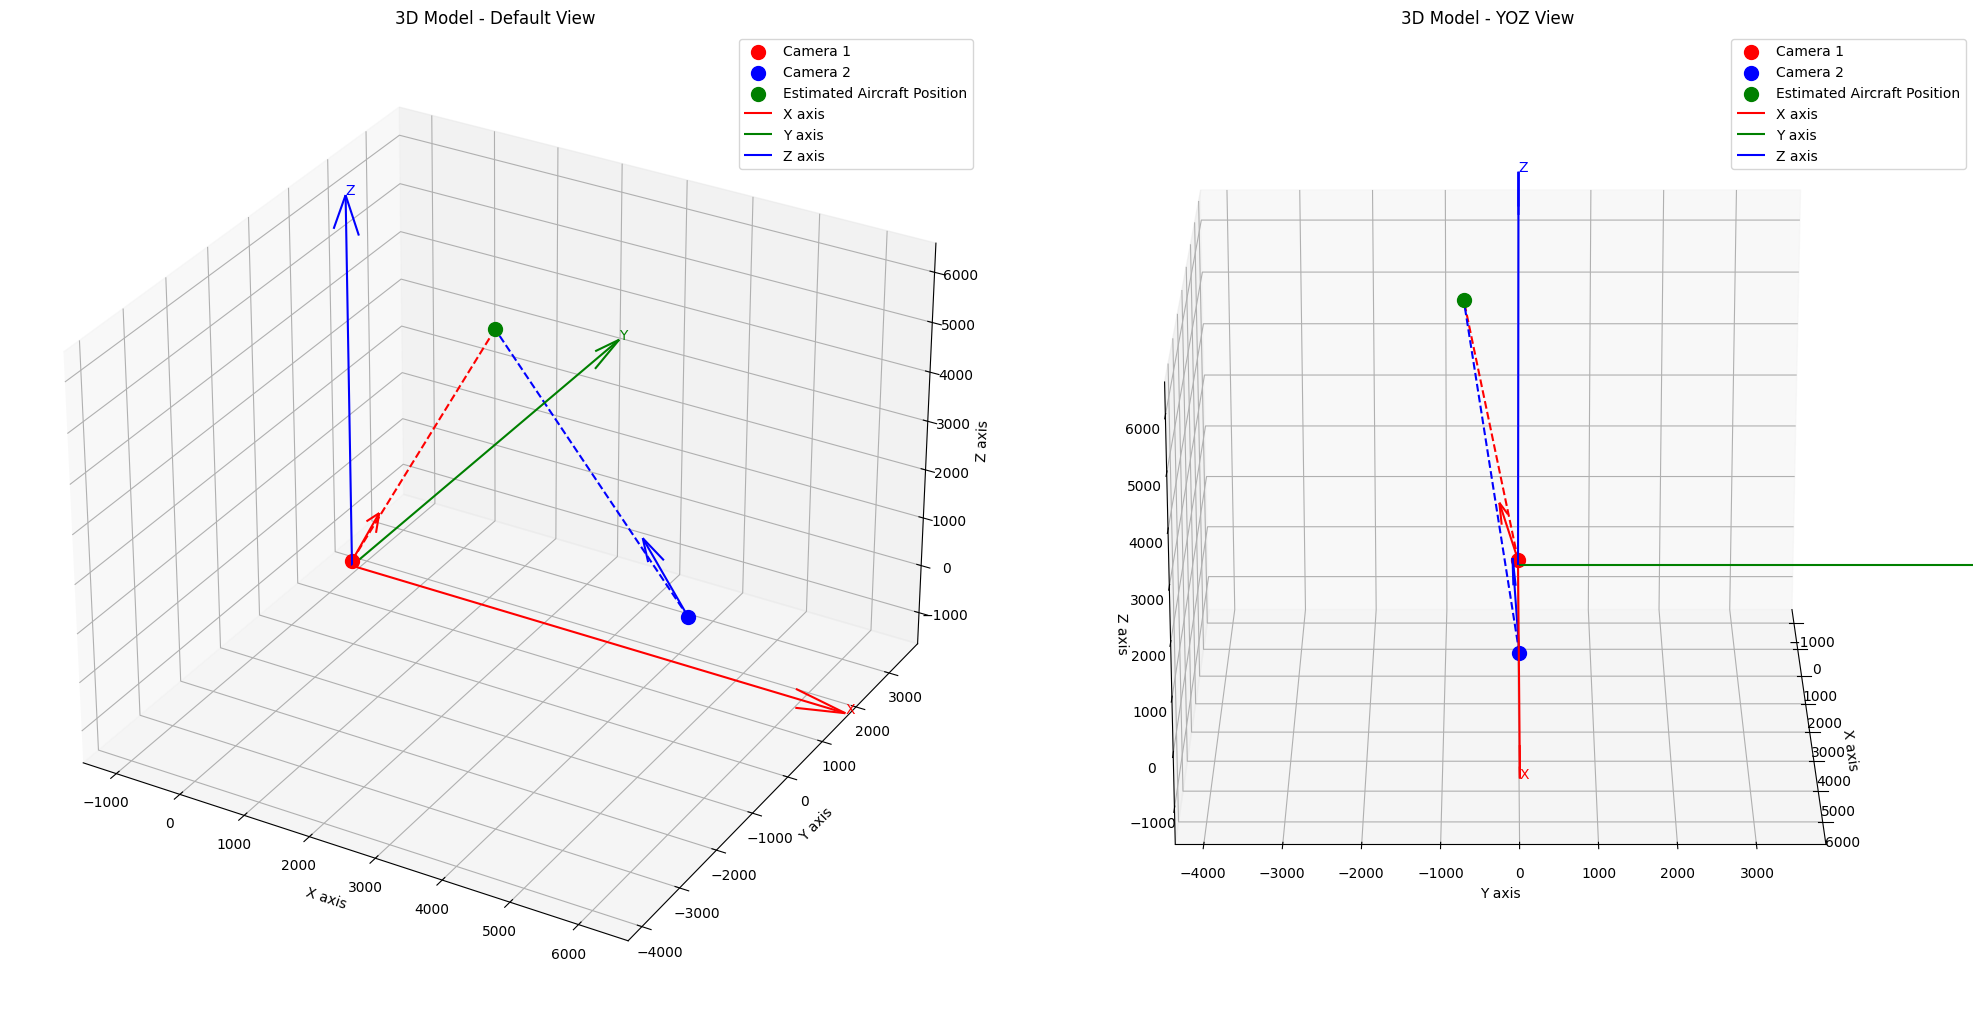

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_3d_model(D, aircraft_position, M1, M2, camera1_pos, camera2_pos):
    fig = plt.figure(figsize=(20, 10))
    
    # Subplot 1: Default view
    ax1 = fig.add_subplot(121, projection='3d')
    plot_subplot(ax1, D, aircraft_position, M1, M2, camera1_pos, camera2_pos, "Default View")
    
    # Subplot 2: YOZ view
    ax2 = fig.add_subplot(122, projection='3d')
    plot_subplot(ax2, D, aircraft_position, M1, M2, camera1_pos, camera2_pos, "YOZ View")
    ax2.view_init(elev=20, azim=0)
    
    plt.tight_layout()
    plt.show()

def plot_subplot(ax, D, aircraft_position, M1, M2, camera1_pos, camera2_pos, view_title):
    # Set scale factor based on camera distance
    scale = D * 0.3  # You can adjust this multiplier to change the relative length

    # Plot cameras
    ax.scatter(*camera1_pos, color='r', s=100, label='Camera 1')
    ax.scatter(*camera2_pos, color='b', s=100, label='Camera 2')

    # Plot camera direction vectors
    ax.quiver(*camera1_pos, *(M1 * scale), color='r')
    ax.quiver(*camera2_pos, *(M2 * scale), color='b')

    # Plot estimated aircraft position
    ax.scatter(*aircraft_position, color='g', s=100, label='Estimated Aircraft Position')

    # Connect cameras to aircraft position
    ax.plot([camera1_pos[0], aircraft_position[0]], 
            [camera1_pos[1], aircraft_position[1]], 
            [camera1_pos[2], aircraft_position[2]], 'r--')
    ax.plot([camera2_pos[0], aircraft_position[0]], 
            [camera2_pos[1], aircraft_position[1]], 
            [camera2_pos[2], aircraft_position[2]], 'b--')

    # Add coordinate axes
    origin = [0, 0, 0]
    axis_length = max(np.max(np.abs(aircraft_position)), D, 
                      np.max(np.abs(camera1_pos)), np.max(np.abs(camera2_pos))) * 1.2
    ax.quiver(*origin, axis_length, 0, 0, color='r', arrow_length_ratio=0.1, label='X axis')
    ax.quiver(*origin, 0, axis_length, 0, color='g', arrow_length_ratio=0.1, label='Y axis')
    ax.quiver(*origin, 0, 0, axis_length, color='b', arrow_length_ratio=0.1, label='Z axis')

    # Set labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title(f'3D Model - {view_title}')

    # Set axis limits
    max_range = np.array([camera1_pos, camera2_pos, aircraft_position, 
                          [axis_length, axis_length, axis_length]]).ptp(axis=0).max() / 2.0
    mid_x = (camera1_pos[0] + camera2_pos[0]) / 2
    mid_y = (camera1_pos[1] + camera2_pos[1] + aircraft_position[1]) / 3
    mid_z = (camera1_pos[2] + camera2_pos[2] + aircraft_position[2]) / 3
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Add text labels for axes
    ax.text(axis_length, 0, 0, "X", color='red')
    ax.text(0, axis_length, 0, "Y", color='green')
    ax.text(0, 0, axis_length, "Z", color='blue')

    ax.legend()

# Sử dụng hàm với dữ liệu từ tính toán trước đó
plot_3d_model(D, aircraft_position, M1, M2, camera1_pos, camera2_pos)
